In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
import missingno as msno
from utils import get_idle_proportion

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('/projects/2/prjs1098/system_analytics_2024/slurm_data')
folder_path_saving_results = Path('./results')


# read data from the cleaning note book
df = pd.read_parquet(folder_path_slurm_data / 'sinfo_cleaned.parquet.gzip')
df.head(n=5)

node                time  state
0  fcn1 2024-11-04 17:03:13  mixed
0  fcn1 2024-11-04 17:03:43  mixed
0  fcn1 2024-11-04 17:04:13  mixed
0  fcn1 2024-11-04 17:04:43  mixed
0  fcn1 2024-11-04 17:05:13  mixed

In [3]:
""" 
Add some useful signals:
NO MISTAKE should happen here. 
"""

# add the node type and get the regular nodes only
df['node_type'] = df['node'].str[0:3]
df = df[df['node_type'].isin(['fcn', 'gcn', 'tcn', 'hcn'])].copy()

# put the time in an interval: if time is in [start-end], we add a tag as start
df['time_30min_interval'] = (df['time']).dt.floor(freq='30min')
df['time_1hour_interval'] = (df['time']).dt.floor(freq='1h')
df['time_2hour_interval'] = (df['time']).dt.floor(freq='2h')
df['time_3hour_interval'] = (df['time']).dt.floor(freq='3h')
df['time_6hour_interval'] = (df['time']).dt.floor(freq='6h')
df['time_12hour_interval'] = (df['time']).dt.floor(freq='12h')
df['time_day_interval'] = (df['time']).dt.floor(freq='d')


# # how long a state last?
# df['duration'] = df.groupby('node')['time'].diff(1).shift(-1)
# # drop the rows that beccome Nan due to shift
# df = df[~(df['duration'].isna())]


# display a sample
N = len(df)//20
display(df.iloc[N: N + 5, :])


# save the data for the machine learning norte book.
df.to_parquet(folder_path_slurm_data/'sinfo_EDA_cleaned.parquet.gzip', compression='gzip')

node                time state node_type time_30min_interval  \
5  fcn6 2024-11-20 02:09:08  idle       fcn 2024-11-20 02:00:00   
5  fcn6 2024-11-20 02:09:41  idle       fcn 2024-11-20 02:00:00   
5  fcn6 2024-11-20 02:11:06  idle       fcn 2024-11-20 02:00:00   
5  fcn6 2024-11-20 02:11:08  idle       fcn 2024-11-20 02:00:00   
5  fcn6 2024-11-20 02:12:41  idle       fcn 2024-11-20 02:00:00   

  time_1hour_interval time_2hour_interval time_3hour_interval  \
5 2024-11-20 02:00:00 2024-11-20 02:00:00          2024-11-20   
5 2024-11-20 02:00:00 2024-11-20 02:00:00          2024-11-20   
5 2024-11-20 02:00:00 2024-11-20 02:00:00          2024-11-20   
5 2024-11-20 02:00:00 2024-11-20 02:00:00          2024-11-20   
5 2024-11-20 02:00:00 2024-11-20 02:00:00          2024-11-20   

  time_6hour_interval time_12hour_interval time_day_interval  
5          2024-11-20           2024-11-20        2024-11-20  
5          2024-11-20           2024-11-20        2024-11-20  
5          2024-11-20           2024-11-20        2024-11-20  
5          2024-11-20           2024-11-20        2024-11-20  
5          2024-11-20           2024-11-20        2024-11-20

In [18]:
""" 
Pick a time interval to do the rest of the analysis
later we put all the codes in a function so we can always change the time_col
easily
NO MISTAKE SHOULD HAPPEN HERE. 
"""
time_col = 'time_6hour_interval' # from here until the moment we get the dataframe for plotting, put it in a function
# take a copy
df_with_duration = df.copy()
# how long does a state last? we are ignoreing those samples outside of the time interval. Does this make sense? Do I do it correclty?
df_with_duration['state_duration'] = df_with_duration.groupby(['node', time_col])['time'].diff(1).shift(-1)
# drop the rows that beccome Nan due to shift
df_with_duration = df_with_duration[~(df_with_duration['state_duration'].isna())]
# show me a sample and tell me as a sanity check what is the maximum duration? It should be lower than time interval
N = len(df_with_duration)//10
display(df_with_duration.iloc[N: N + 6, :], df_with_duration['state_duration'].describe(percentiles=[0.999]))
"""  
Here we see the bad samples that we had in the clening notebook. Some of the states (they are rare) takes 1.5 hour.
But 99.9 percent of the states takes around 5 minutes.
"""

node                time      state node_type time_30min_interval  \
15  gcn130 2024-11-16 01:34:45  draining@       gcn 2024-11-16 01:30:00   
15  gcn130 2024-11-16 01:35:44  draining@       gcn 2024-11-16 01:30:00   
15  gcn130 2024-11-16 01:35:45  draining@       gcn 2024-11-16 01:30:00   
15  gcn130 2024-11-16 01:36:15  draining@       gcn 2024-11-16 01:30:00   
15  gcn130 2024-11-16 01:36:45  draining@       gcn 2024-11-16 01:30:00   
15  gcn130 2024-11-16 01:37:45  draining@       gcn 2024-11-16 01:30:00   

   time_1hour_interval time_2hour_interval time_3hour_interval  \
15 2024-11-16 01:00:00          2024-11-16          2024-11-16   
15 2024-11-16 01:00:00          2024-11-16          2024-11-16   
15 2024-11-16 01:00:00          2024-11-16          2024-11-16   
15 2024-11-16 01:00:00          2024-11-16          2024-11-16   
15 2024-11-16 01:00:00          2024-11-16          2024-11-16   
15 2024-11-16 01:00:00          2024-11-16          2024-11-16   

   time_6hour_interval time_12hour_interval time_day_interval  state_duration  
15          2024-11-16           2024-11-16        2024-11-16 0 days 00:00:59  
15          2024-11-16           2024-11-16        2024-11-16 0 days 00:00:01  
15          2024-11-16           2024-11-16        2024-11-16 0 days 00:00:30  
15          2024-11-16           2024-11-16        2024-11-16 0 days 00:00:30  
15          2024-11-16           2024-11-16        2024-11-16 0 days 00:01:00  
15          2024-11-16           2024-11-16        2024-11-16 0 days 00:01:00

count                     53059462
mean     0 days 00:00:39.347082524
std      0 days 00:00:33.637170704
min                0 days 00:00:01
50%                0 days 00:00:30
99.9%              0 days 00:02:34
max                0 days 01:16:38
Name: state_duration, dtype: object

'  \nHere we see the bad samples that we had in the clening notebook. Some of the states (they are rare) takes 1.5 hour.\nBut 99.9 percent of the states takes around 5 minutes.\n'

In [19]:
"""  
No mistake should happen here.
"""
# compute the total time a node was in a state in a given inteval
df_temp = df_with_duration.groupby(['node', time_col, 'state' ], as_index=False)[['state_duration']].sum()
df_temp.sort_values(['node', time_col], inplace=True)
df_temp.rename(columns={'state_duration':'state_duration_in_interval'}, inplace=True)


In [20]:

# show a smaple
N = len(df_temp)//10
display(df_temp.iloc[N-4: N + 10, :], "The maximum duration for a node in a state is:",df_temp['state_duration_in_interval'].max())
# note it is ok to get maximum duration smaller than the time interval
# we can change this behavior by doing the diff the way we did in the previous cell

node time_6hour_interval       state state_duration_in_interval
16483  gcn142 2024-11-11 06:00:00  completing            0 days 00:03:40
16484  gcn142 2024-11-11 06:00:00        idle            0 days 01:13:49
16485  gcn142 2024-11-11 06:00:00       mixed            0 days 04:40:28
16486  gcn142 2024-11-11 12:00:00  completing            0 days 00:03:00
16487  gcn142 2024-11-11 12:00:00        idle            0 days 00:05:00
16488  gcn142 2024-11-11 12:00:00       mixed            0 days 05:43:10
16489  gcn142 2024-11-11 18:00:00       mixed            0 days 05:59:27
16490  gcn142 2024-11-12 00:00:00       mixed            0 days 05:58:25
16491  gcn142 2024-11-12 06:00:00   allocated            0 days 00:34:18
16492  gcn142 2024-11-12 06:00:00  completing            0 days 00:04:26
16493  gcn142 2024-11-12 06:00:00        idle            0 days 02:11:55
16494  gcn142 2024-11-12 06:00:00       mixed            0 days 03:08:48
16495  gcn142 2024-11-12 12:00:00   allocated            0 days 03:37:29
16496  gcn142 2024-11-12 12:00:00  completing            0 days 00:01:00

'The maximum duration for a node in a state is:'

Timedelta('0 days 05:59:53')

In [21]:

"""  
No mistake here as well, crucial for later usages.
"""

# get the total time for all the states
df_total = df_temp.groupby(['node', time_col], as_index=False)['state_duration_in_interval'].sum().copy()
df_total.rename(columns={'state_duration_in_interval':'all_state_durations_in_interval'}, inplace=True)

# get the idle time for the states
df_idle = df_temp[(df_temp['state']=='idle')].copy()
df_idle.drop(columns='state', inplace=True)
df_idle.rename(columns={'state_duration_in_interval':'idle_duration'}, inplace=True)

# join the two data frame based on node and time
df_stat = pd.merge(df_idle, df_total, how='outer', on=['node', time_col])
df_stat.fillna(value=pd.Timedelta('0s'), inplace=True)
df_stat.sort_values(['node', time_col], inplace=True)

# divide the total idle duration in the interval by the total time of all the states: 
# we get proportion of the time that idle happened in the interval
df_stat['idle_proportion'] = (df_stat['idle_duration'] / df_stat['all_state_durations_in_interval'])



In [23]:

# show the data frame that we have
display(df_total.tail(n=10), df_idle.tail(n=10), df_stat.tail(n=10))

node time_6hour_interval all_state_durations_in_interval
98422  tcn999 2024-11-18 00:00:00                 0 days 05:58:36
98423  tcn999 2024-11-18 06:00:00                 0 days 05:58:33
98424  tcn999 2024-11-18 12:00:00                 0 days 05:58:35
98425  tcn999 2024-11-18 18:00:00                 0 days 05:57:34
98426  tcn999 2024-11-19 00:00:00                 0 days 05:58:54
98427  tcn999 2024-11-19 06:00:00                 0 days 05:58:37
98428  tcn999 2024-11-19 12:00:00                 0 days 05:58:39
98429  tcn999 2024-11-19 18:00:00                 0 days 05:58:42
98430  tcn999 2024-11-20 00:00:00                 0 days 05:58:52
98431  tcn999 2024-11-20 06:00:00                 0 days 05:11:12

node time_6hour_interval   idle_duration
164851  tcn999 2024-11-18 00:00:00 0 days 05:58:36
164852  tcn999 2024-11-18 06:00:00 0 days 05:58:33
164854  tcn999 2024-11-18 12:00:00 0 days 05:05:55
164858  tcn999 2024-11-18 18:00:00 0 days 01:05:30
164860  tcn999 2024-11-19 00:00:00 0 days 05:58:54
164861  tcn999 2024-11-19 06:00:00 0 days 05:58:37
164864  tcn999 2024-11-19 12:00:00 0 days 04:25:57
164868  tcn999 2024-11-19 18:00:00 0 days 04:36:07
164870  tcn999 2024-11-20 00:00:00 0 days 05:58:52
164872  tcn999 2024-11-20 06:00:00 0 days 04:59:33

node time_6hour_interval   idle_duration  \
98422  tcn999 2024-11-18 00:00:00 0 days 05:58:36   
98423  tcn999 2024-11-18 06:00:00 0 days 05:58:33   
98424  tcn999 2024-11-18 12:00:00 0 days 05:05:55   
98425  tcn999 2024-11-18 18:00:00 0 days 01:05:30   
98426  tcn999 2024-11-19 00:00:00 0 days 05:58:54   
98427  tcn999 2024-11-19 06:00:00 0 days 05:58:37   
98428  tcn999 2024-11-19 12:00:00 0 days 04:25:57   
98429  tcn999 2024-11-19 18:00:00 0 days 04:36:07   
98430  tcn999 2024-11-20 00:00:00 0 days 05:58:52   
98431  tcn999 2024-11-20 06:00:00 0 days 04:59:33   

      all_state_durations_in_interval  idle_proportion  
98422                 0 days 05:58:36           1.0000  
98423                 0 days 05:58:33           1.0000  
98424                 0 days 05:58:35           0.8531  
98425                 0 days 05:57:34           0.1832  
98426                 0 days 05:58:54           1.0000  
98427                 0 days 05:58:37           1.0000  
98428                 0 days 05:58:39           0.7415  
98429                 0 days 05:58:42           0.7698  
98430                 0 days 05:58:52           1.0000  
98431                 0 days 05:11:12           0.9626

In [24]:

# pick a time col again, the function does the same thing as above for a specifc interval
time_col = 'time_12hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
display(df_total.head(), df_idle.head(), df_stat.head())



# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")
display(df_stat_pivot.head())

node time_12hour_interval all_state_durations_in_interval
0  fcn1  2024-11-04 12:00:00                 0 days 06:56:30
1  fcn1  2024-11-05 00:00:00                 0 days 11:59:20
2  fcn1  2024-11-05 12:00:00                 0 days 11:59:55
3  fcn1  2024-11-06 00:00:00                 0 days 11:59:19
4  fcn1  2024-11-06 12:00:00                 0 days 11:59:39

node time_12hour_interval   idle_duration
13  fcn1  2024-11-09 00:00:00 0 days 02:59:30
15  fcn1  2024-11-09 12:00:00 0 days 11:59:40
16  fcn1  2024-11-10 00:00:00 0 days 11:59:03
18  fcn1  2024-11-10 12:00:00 0 days 09:23:07
23  fcn1  2024-11-11 12:00:00 0 days 01:13:04

node time_12hour_interval idle_duration all_state_durations_in_interval  \
0  fcn1  2024-11-04 12:00:00        0 days                 0 days 06:56:30   
1  fcn1  2024-11-05 00:00:00        0 days                 0 days 11:59:20   
2  fcn1  2024-11-05 12:00:00        0 days                 0 days 11:59:55   
3  fcn1  2024-11-06 00:00:00        0 days                 0 days 11:59:19   
4  fcn1  2024-11-06 12:00:00        0 days                 0 days 11:59:39   

   idle_proportion  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

node                  fcn1   fcn10  fcn100  fcn101  fcn102  fcn103  fcn104  \
time_12hour_interval                                                         
2024-11-04 12:00       0.0  0.0240     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00       0.0  0.7226     1.0     1.0     1.0     1.0     1.0   
2024-11-05 12:00       0.0  0.3128     1.0     1.0     1.0     1.0     1.0   
2024-11-06 00:00       0.0  0.6942     1.0     1.0     1.0     1.0     1.0   
2024-11-06 12:00       0.0  0.6308     1.0     1.0     1.0     1.0     1.0   

node                  fcn105  fcn106  fcn107  fcn108  fcn109   fcn11  fcn110  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0     1.0     1.0     1.0  0.0000     1.0   
2024-11-05 00:00         1.0     1.0     1.0     1.0     1.0  0.4467     1.0   
2024-11-05 12:00         1.0     1.0     1.0     1.0     1.0  0.3567     1.0   
2024-11-06 00:00         1.0     1.0     1.0     1.0     1.0  0.8704     1.0   
2024-11-06 12:00         1.0     1.0     1.0     1.0     1.0  0.7890     1.0   

node                  fcn111  fcn112  fcn113  fcn114  fcn115  fcn116  fcn117  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-06 00:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-06 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   

node                  fcn118  fcn119   fcn12  fcn120   fcn13   fcn14   fcn15  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0  0.0240     1.0  0.0240  0.0000  0.0240   
2024-11-05 00:00         1.0     1.0  0.2759     1.0  0.7019  0.0000  0.7192   
2024-11-05 12:00         1.0     1.0  0.6519     1.0  0.2441  0.0000  0.7171   
2024-11-06 00:00         1.0     1.0  0.6669     1.0  0.8746  0.0293  0.8815   
2024-11-06 12:00         1.0     1.0  0.0000     1.0  0.4929  0.7785  0.2850   

node                   fcn16   fcn17   fcn18   fcn19    fcn2   fcn20   fcn21  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0253  0.0240  0.0240  0.9938  0.0012  0.0240  0.0240   
2024-11-05 00:00      0.7633  0.7178  0.7313  1.0000  0.0000  0.7313  0.7313   
2024-11-05 12:00      0.0899  0.0913  0.9094  1.0000  0.0000  0.9115  0.9115   
2024-11-06 00:00      0.1874  0.1972  0.9610  1.0000  0.1609  0.9610  0.9749   
2024-11-06 12:00      0.8565  0.8537  0.8537  0.9958  0.0000  0.8544  0.8175   

node                   fcn22   fcn23   fcn24   fcn25   fcn26   fcn27   fcn28  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0240  0.0240  0.0240  0.9938  0.0240  0.0240  0.0240   
2024-11-05 00:00      0.7313  0.7313  0.7313  1.0000  0.0000  0.4105  0.7313   
2024-11-05 12:00      0.7260  0.9652  1.0000  1.0000  0.8967  1.0000  1.0000   
2024-11-06 00:00      0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 12:00      0.0000  0.8168  0.8168  0.9951  0.8217  0.8203  0.8461   

node                   fcn29    fcn3   fcn30   fcn31   fcn32   fcn33   fcn34  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0253  0.0000  0.0240  0.0240  0.0253  0.0240  0.0240   
2024-11-05 00:00      0.0000  0.0000  0.7313  0.6345  0.4456  0.3052  0.7313   
2024-11-05 12:00      0.9045  0.0335  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 00:00      1.0000  0.6012  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 12:00      0.8488  0.5772  0.8642  0.8537  0.8356  0.8251  0.8140   

node                   fcn35   fcn36   fcn37   fcn38   fcn39  fcn4   fcn40  \
time_12ho

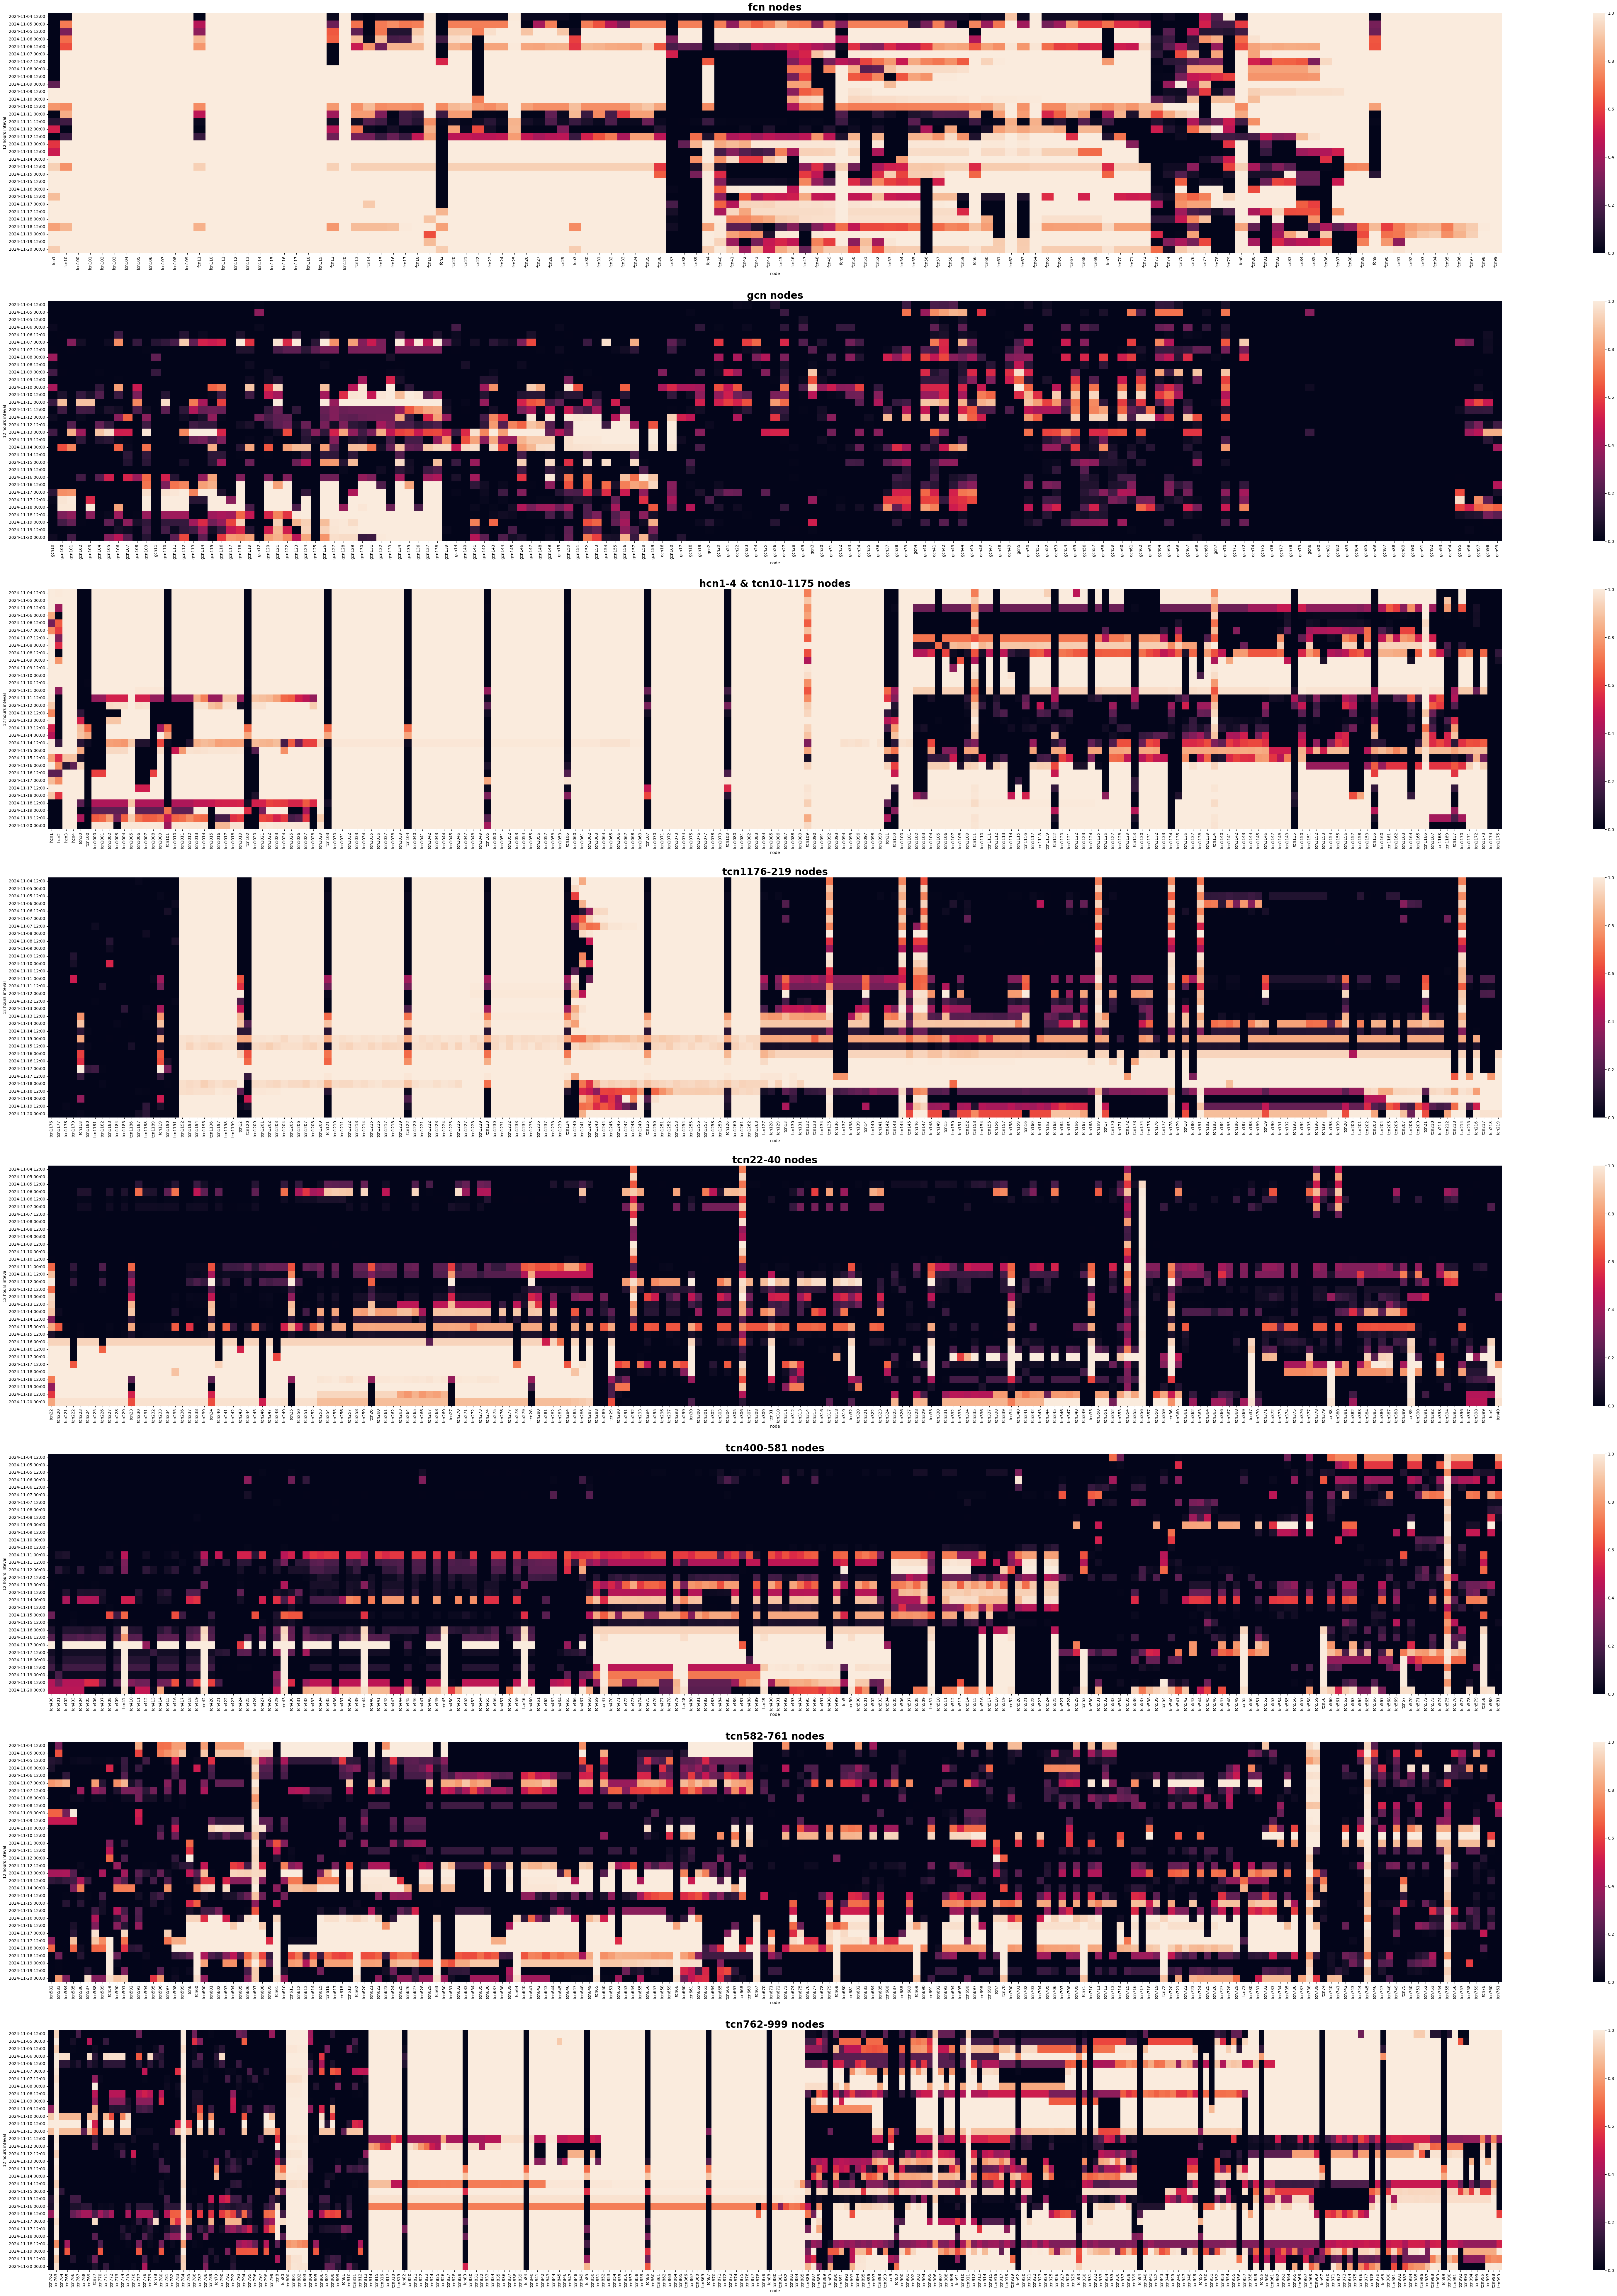

In [25]:

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 100))
# Define the ranges to plot and corresponding titles for each subplot
ranges = [(0, 120), (120, 275), (275, 475), (475, 675), (675, 875), (875, 1075), (1075, 1275), (1275, None)]
titles = [
    "fcn nodes",
    "gcn nodes",
    "hcn1-4 & tcn10-1175 nodes",
    "tcn1176-219 nodes",
   "tcn22-40 nodes",
   "tcn400-581 nodes",
   "tcn582-761 nodes",
   "tcn762-999 nodes"
]



map_time_column_names = {"time_30min_interval": "30 minutes interval",
                         "time_1hour_interval": "1 hour interval",
                         "time_3hour_interval": "3 hours interval",
                         "time_6hour_interval": "6 hours interval",
                         "time_12hour_interval": "12 hours inteval",
                         "time_day_interval": "1 day interval"
                             }


# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_stat_pivot.iloc[:, start:end], ax=ax[i], vmin=0, vmax=1, xticklabels=True, yticklabels=True,
                cbar=True, cbar_kws={'orientation': 'vertical'})
    
    ax[i].set_title(title, fontsize=24, fontweight="bold")  # Set title for each subplot
    ax[i].set_ylabel(map_time_column_names[time_col])

fig.savefig(folder_path_saving_results/f"nodes_idle_partition_{time_col}.pdf", transparent=True)
fig.savefig(folder_path_saving_results/f"nodes_idle_partition_{time_col}.png", dpi=200)
plt.show()

# move the figures to the laptop for better visibility
# scp -r teimourh@snellius:/home/teimourh/slurm_energy_ml/results .



In [26]:
"""  
sort the data form high to low occupied nodes
"""
ascending_node_names = df_stat_pivot.sum(axis=0).sort_values(ascending=True).index.to_list()
df_sorted_nodes = df_stat_pivot[ascending_node_names].copy()
df_sorted_nodes.head()

node                  tcn1174  tcn702  tcn1177  tcn1176  tcn179  tcn703  gcn4  \
time_12hour_interval                                                            
2024-11-04 12:00          0.0     0.0      0.0      0.0     0.0     0.0   0.0   
2024-11-05 00:00          0.0     0.0      0.0      0.0     0.0     0.0   0.0   
2024-11-05 12:00          0.0     0.0      0.0      0.0     0.0     0.0   0.0   
2024-11-06 00:00          0.0     0.0      0.0      0.0     0.0     0.0   0.0   
2024-11-06 12:00          0.0     0.0      0.0      0.0     0.0     0.0   0.0   

node                  tcn288  tcn535  tcn423  gcn89  gcn93  gcn48  gcn90  \
time_12hour_interval                                                       
2024-11-04 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   

node                  tcn559  gcn92  gcn91  gcn94  tcn321  gcn85  gcn86  \
time_12hour_interval                                                      
2024-11-04 12:00         0.0    0.0    0.0    0.0     0.0    0.0    0.0   
2024-11-05 00:00         0.0    0.0    0.0    0.0     0.0    0.0    0.0   
2024-11-05 12:00         0.0    0.0    0.0    0.0     0.0    0.0    0.0   
2024-11-06 00:00         0.0    0.0    0.0    0.0     0.0    0.0    0.0   
2024-11-06 12:00         0.0    0.0    0.0    0.0     0.0    0.0    0.0   

node                  gcn87  gcn88  gcn81  gcn79  gcn76  gcn77  gcn78  gcn74  \
time_12hour_interval                                                           
2024-11-04 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

node                  gcn80  gcn71  tcn557  gcn75  gcn83  gcn84  tcn523  \
time_12hour_interval                                                      
2024-11-04 12:00        0.0    0.0     0.0    0.0    0.0    0.0     0.0   
2024-11-05 00:00        0.0    0.0     0.0    0.0    0.0    0.0     0.0   
2024-11-05 12:00        0.0    0.0     0.0    0.0    0.0    0.0     0.0   
2024-11-06 00:00        0.0    0.0     0.0    0.0    0.0    0.0     0.0   
2024-11-06 12:00        0.0    0.0     0.0    0.0    0.0    0.0     0.0   

node                  gcn82  tcn510  tcn88  tcn428  tcn1178  tcn1184  tcn1189  \
time_12hour_interval                                                            
2024-11-04 12:00        0.0     0.0    0.0     0.0      0.0   0.0000   0.0000   
2024-11-05 00:00        0.0     0.0    0.0     0.0      0.0   0.0000   0.0000   
2024-11-05 12:00        0.0     0.0    0.0     0.0      0.0   0.0021   0.0000   
2024-11-06 00:00        0.0     0.0    0.0     0.0      0.0   0.0000   0.0007   
2024-11-06 12:00        0.0     0.0    0.0     0.0      0.0   0.0000   0.0000   

node                  gcn28   gcn35  gcn7  tcn1186  tcn1187  tcn1182  tcn1185  \
time_12hour_interval                                                            
2024-11-04 12:00        0.0  0.0000   0.0      0.0   0.0228   0.0024      0.0   
2024-11-05 00:00        0.0  0.0000   0.0      0.0   0.0000   0.0000      0.0   
2024-11-05 12:00        0.0  0.0000   0.0      0.0   0.0000   0.0000      0.0   
2024-11-06 00:00        0.0  0.0014   0.0      0.0   0.0000   0.0000      0.0   
2024-11-06 12:00        0.0  0.0014   0.0      0.0   0.0000   0.0000      0.0   

node                  tcn1191  tcn1180  tcn417  tcn1175  tcn327  tcn1181  \
time_12hour_interval                                                      

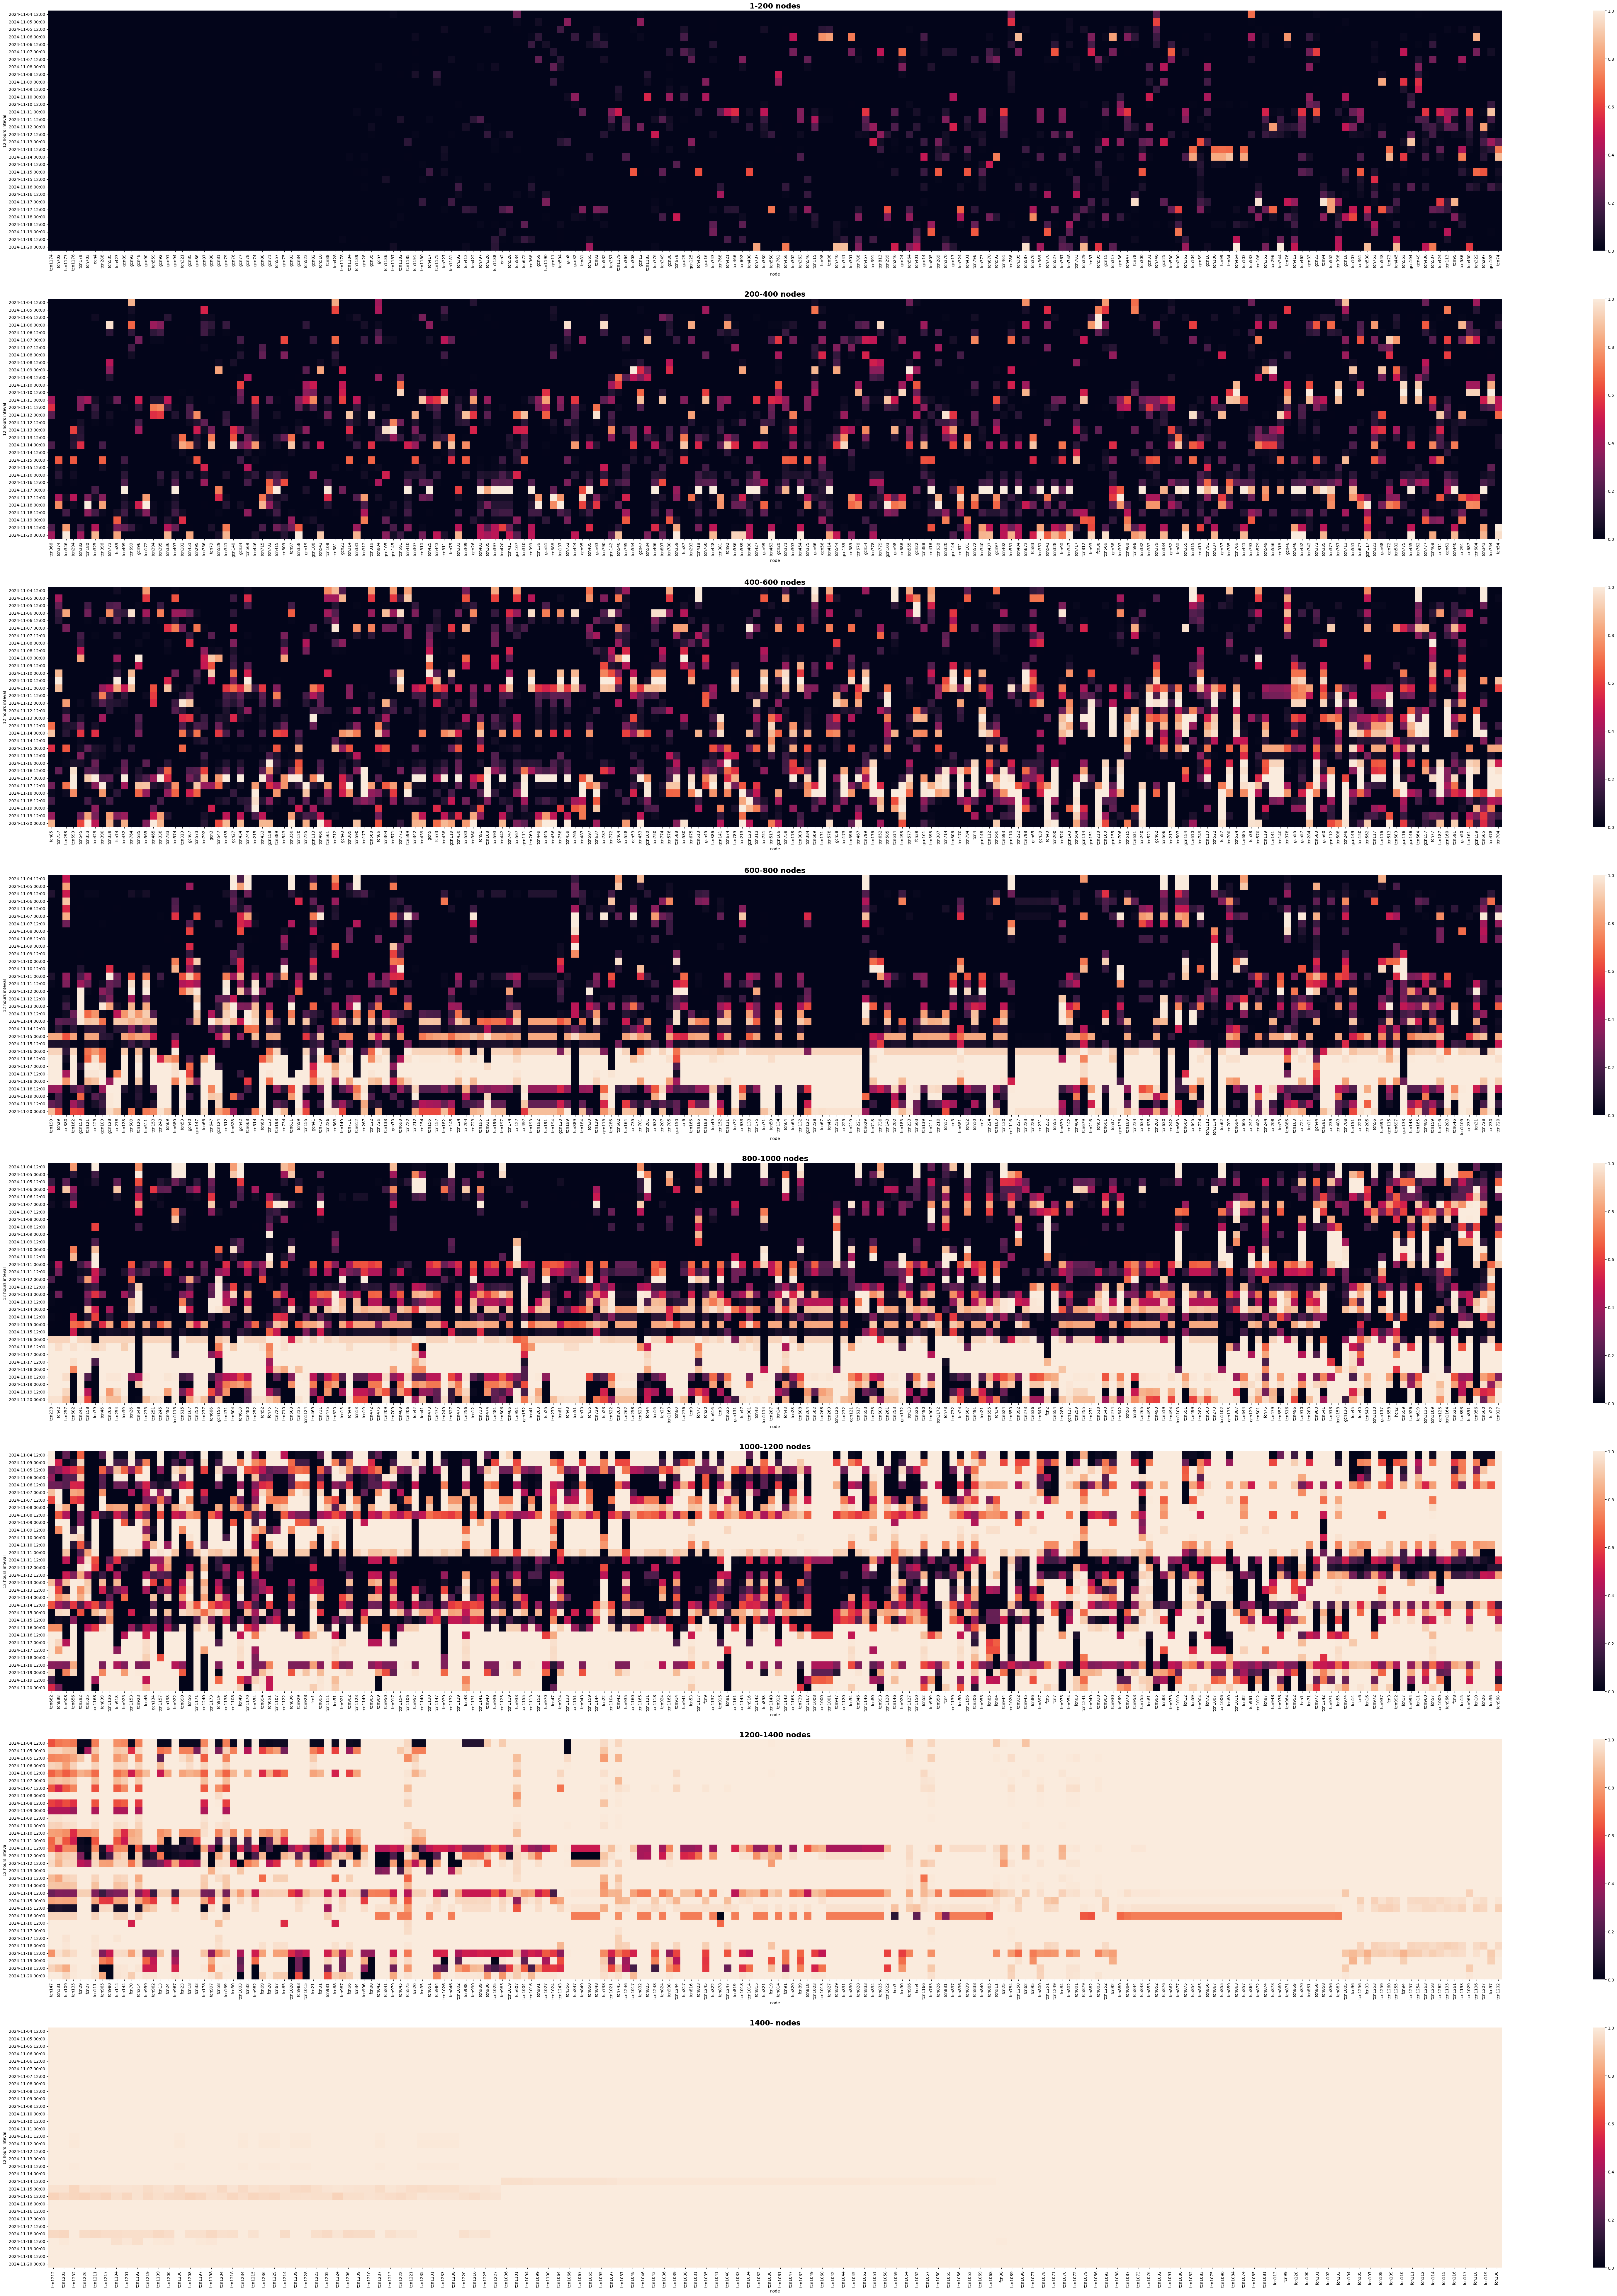

In [27]:

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 100))
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, None)]
titles = [
    "1-200 nodes",
    "200-400 nodes",
    "400-600 nodes",
    "600-800 nodes",
   "800-1000 nodes",
   "1000-1200 nodes",
   "1200-1400 nodes",
   "1400- nodes",
]

# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_sorted_nodes.iloc[:, start:end], vmin=0, vmax=1, xticklabels=True, yticklabels=True,
                ax=ax[i], cbar=True, cbar_kws={'orientation': 'vertical'})
    ax[i].set_title(title, fontsize=18, fontweight="bold")  # Set title for each subplot
    ax[i].set_ylabel(map_time_column_names[time_col])
    # Set x and y tick parameters to bold font
    # ax[i].tick_params(axis='x', labelsize=12)  # Bold x-tick labels
    # ax[i].tick_params(axis='y', labelsize=12)   # Bold y-tick labels

    # ax[i].xaxis.set_tick_params(labelsize=12)
    # ax[i].yaxis.set_tick_params(labelsize=12)
fig.savefig(folder_path_saving_results/f"nodes_idle_ranked_{time_col}.pdf", transparent=True)
fig.savefig(folder_path_saving_results/f"nodes_idle_ranked_{time_col}.png", dpi=200)
plt.show()

In [28]:
"""  
DO WE HAVE MISSING VALUES? It is important to see if there is any missing value in our measurements.
We have to look at start and end time for all series.
Do they have the same length? Do they have the same frequency?
It seems that for larger time interval all the series have the same lenght, but for interval 
less than and equal to 2 hours some series have missing values. ==>> WHAT are these nodes? see next cell
"""
# select different time_interval: If we use the data with 1 hour inteval do we get any missing values?
time_col = 'time_1hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# find the min and max time and the number of samples for each node
df_stat_min_time_max_time = df_stat.groupby('node', as_index=False)[time_col].agg(['min', 'max', 'count'])
# find the measurement frequency for each node. Is it the same with time col?
df_stat_freq = df_stat.groupby('node')[time_col].diff(1).value_counts()
display(df_stat_min_time_max_time.sample(n=10), df_stat_min_time_max_time.describe(), df_stat_freq)

node                 min                 max  count
842    tcn371 2024-11-04 17:00:00 2024-11-20 11:00:00    379
425   tcn1130 2024-11-04 17:00:00 2024-11-20 11:00:00    379
1216   tcn709 2024-11-04 17:00:00 2024-11-20 11:00:00    379
593    tcn145 2024-11-04 17:00:00 2024-11-20 11:00:00    379
553   tcn1246 2024-11-04 17:00:00 2024-11-20 11:00:00    379
865    tcn392 2024-11-04 17:00:00 2024-11-20 11:00:00    379
1157   tcn656 2024-11-04 17:00:00 2024-11-20 11:00:00    379
429   tcn1134 2024-11-04 17:00:00 2024-11-20 11:00:00    379
409   tcn1116 2024-11-04 17:00:00 2024-11-20 11:00:00    379
66      fcn50 2024-11-04 17:00:00 2024-11-20 11:00:00    379

min                  max   count
count                 1538                 1538  1538.0
mean   2024-11-04 17:00:00  2024-11-20 11:00:00   379.0
min    2024-11-04 17:00:00  2024-11-20 11:00:00   379.0
25%    2024-11-04 17:00:00  2024-11-20 11:00:00   379.0
50%    2024-11-04 17:00:00  2024-11-20 11:00:00   379.0
75%    2024-11-04 17:00:00  2024-11-20 11:00:00   379.0
max    2024-11-04 17:00:00  2024-11-20 11:00:00   379.0
std                    NaN                  NaN     0.0

time_1hour_interval
0 days 01:00:00    581364
Name: count, dtype: int64

'  \nIt is very confusing why not all the nodes have missing values? Does this mean that the missing value\nis because of the fact that these nodes did not appear in sinfo or it was measurement error?\n'

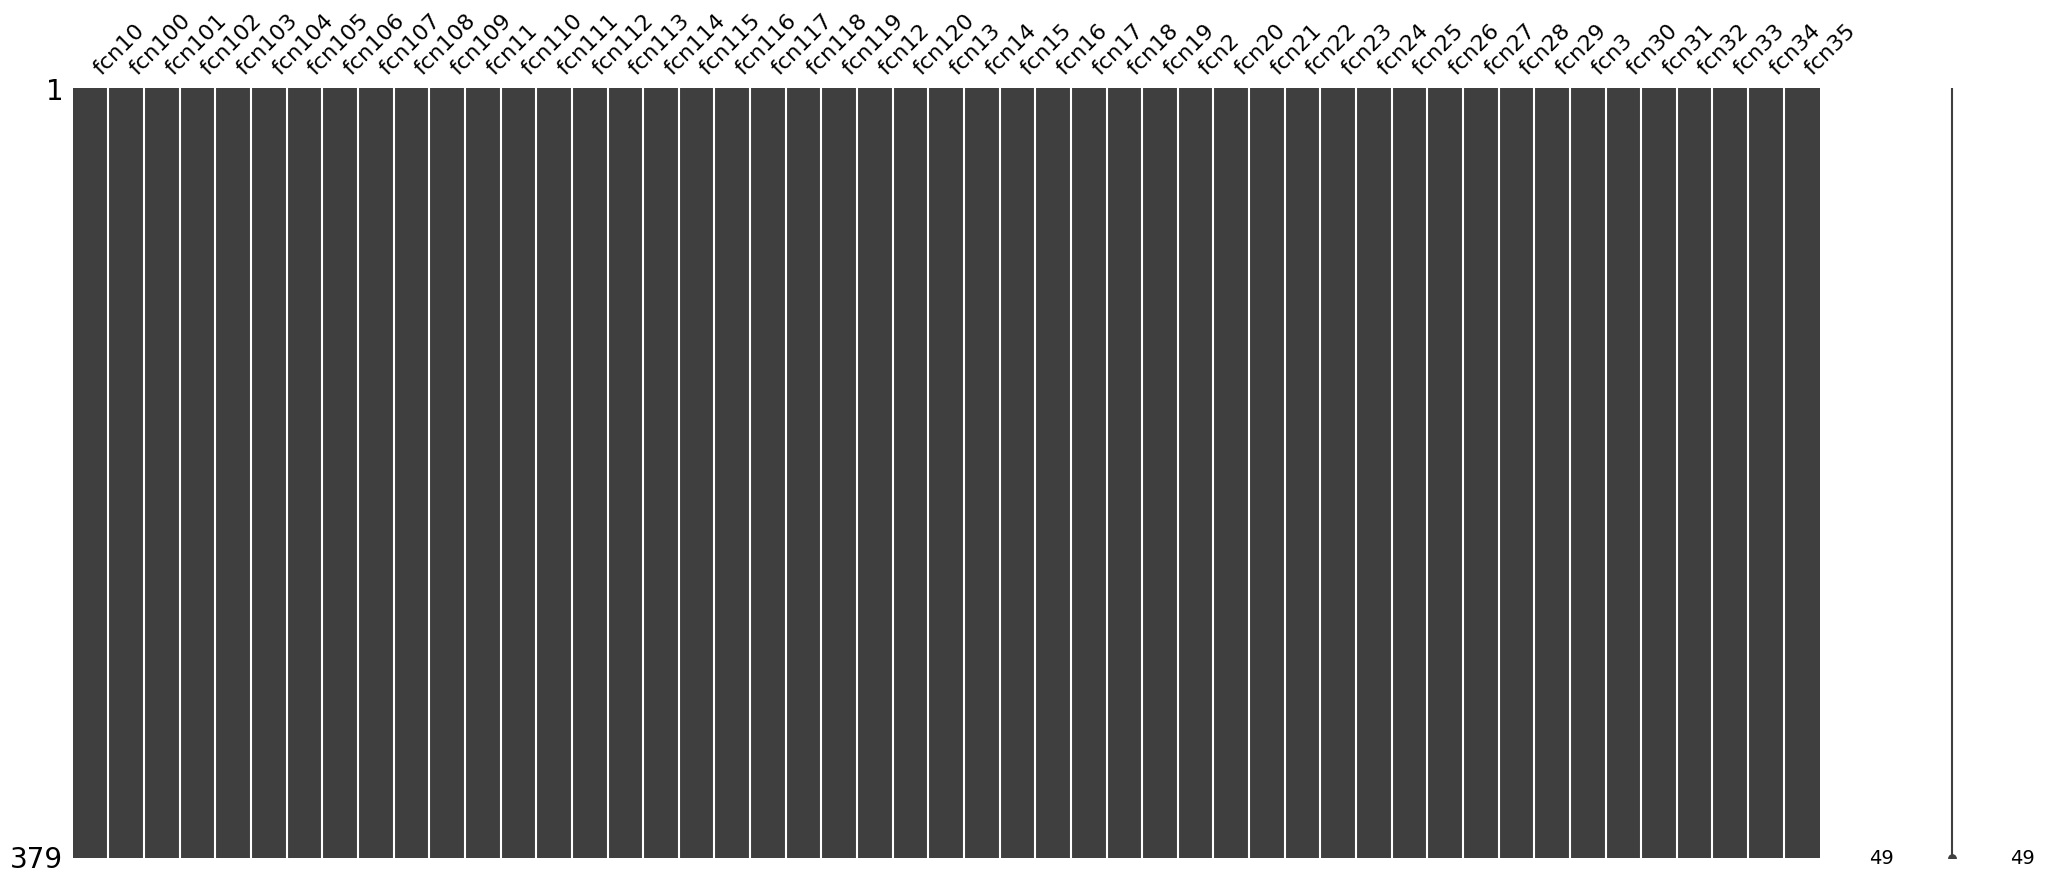

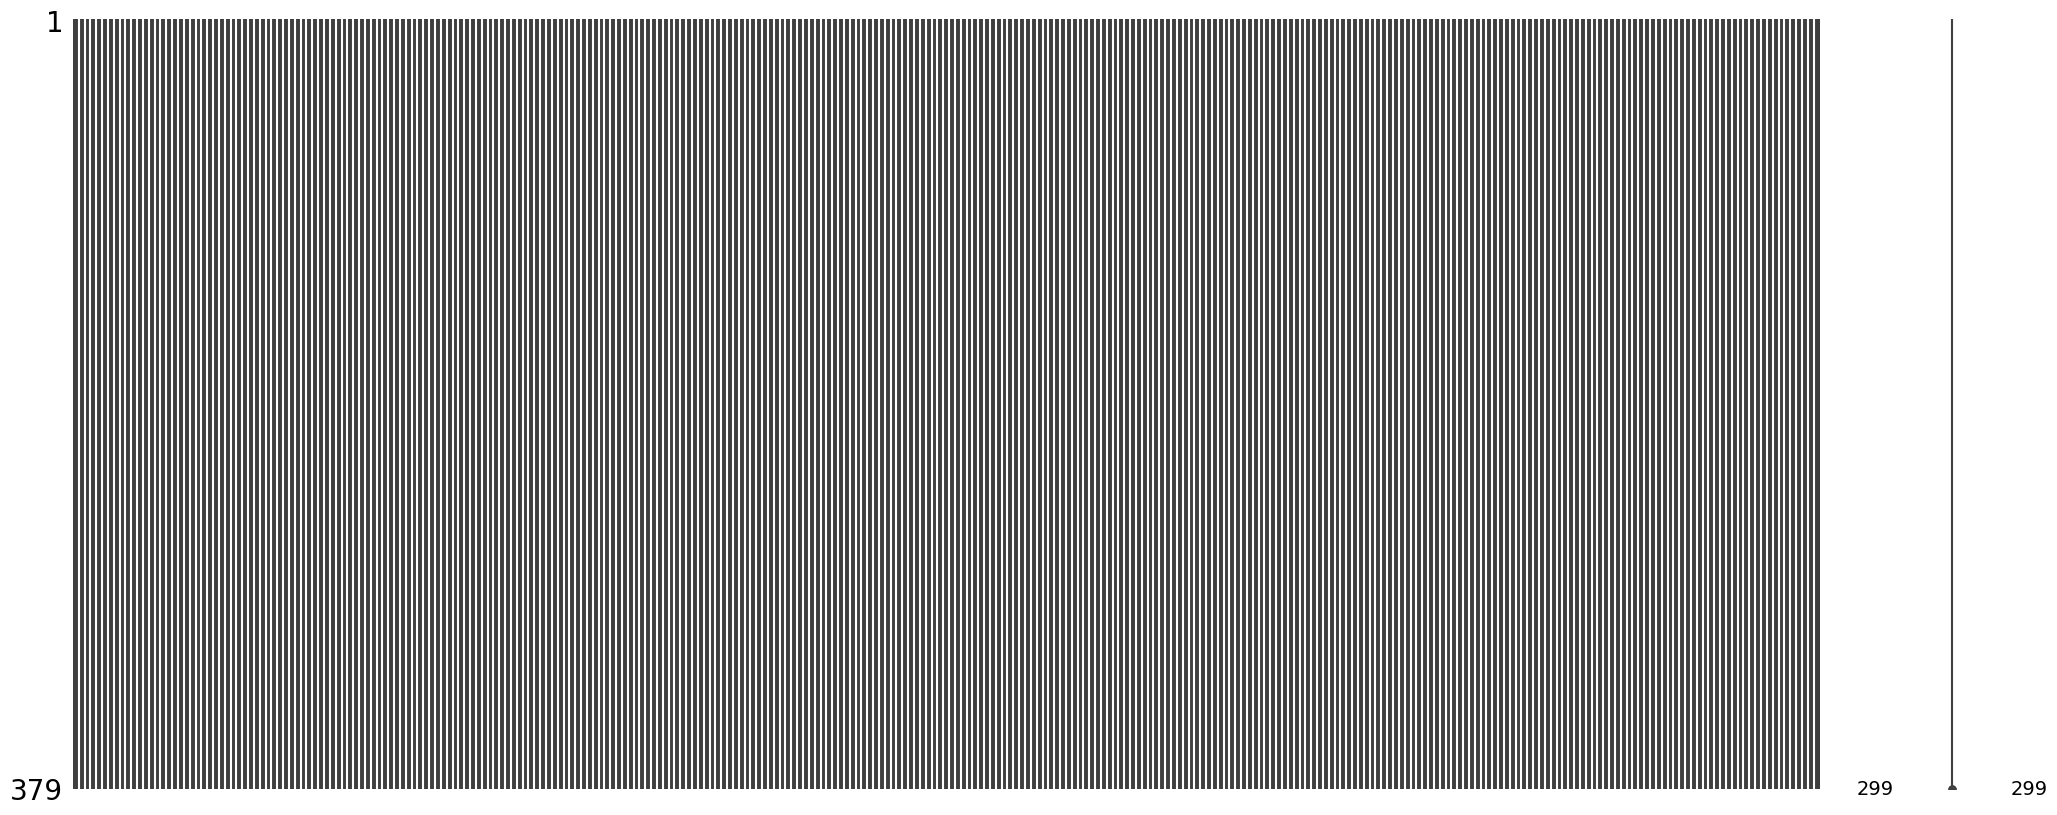

In [29]:
"""  
Show the some of the ndoes that have missing values
show the all the nodes that have missing values
The white spaces show the sample that is missing in the data for a  specific node.
"""
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")

node_names_with_high_nan_values = df_stat_pivot.isna().sum().sort_values(ascending=False).index.to_list()
df_sorted_nodes = df_stat_pivot[node_names_with_high_nan_values].copy()
msno.matrix(df_stat_pivot.iloc[:,1:50])
msno.matrix(df_sorted_nodes.iloc[:, 1:300])

"""  
It is very confusing why not all the nodes have missing values? Does this mean that the missing value
is because of the fact that these nodes did not appear in sinfo or it was measurement error?
"""







In [30]:
"""  
I like to see the seasnoality for the state.
It could be the pattern repeat it self:
hourly resolution ==> day plot
2 hourrly ==> day plot
.
.
.
12 hourly == weekly plot
"""


# pick a time col again, the function does the same thing as above for a specifc interval
time_col = 'time_1hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# get name of the day
df_stat['day'] = df_stat[time_col].dt.day_name()
# get hour of the day
df_stat['hour'] = df_stat[time_col].dt.hour
# do the adverage based on node and day and hour
df_temp = df_stat.groupby(['node', 'day', 'hour'], as_index=False)['idle_proportion'].mean()


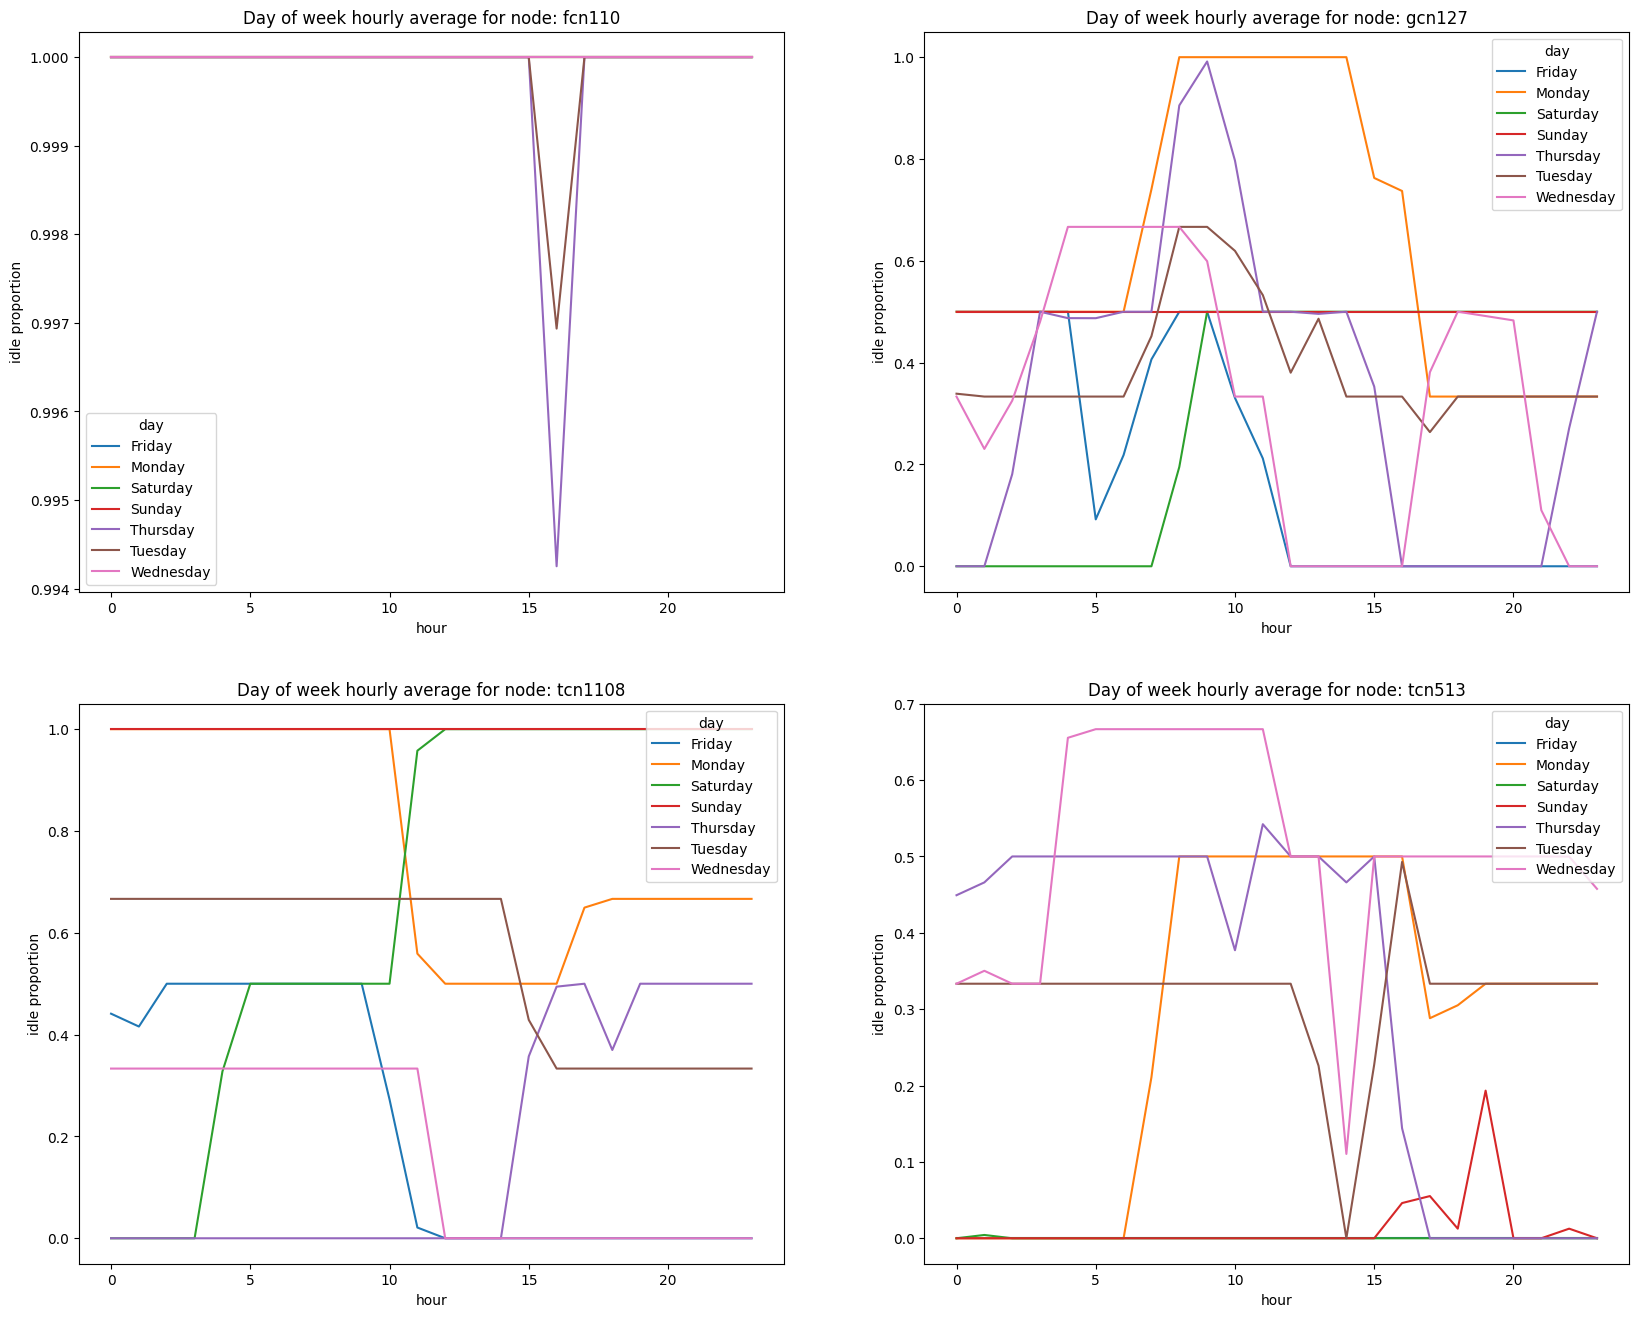

In [31]:
"""  
With getting more and more data I expect these plots to let us know
is there any seasnoality in the signal, e.g. during some hours of the day a node
is always busy ...
"""

# pick random number between 0:1550 for plotting
node_list = df_stat['node'].unique()[[13, 150, 400, 1000]]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))
node_type_loc = { 1:ax[0,0], 2:ax[0,1], 3:ax[1,0], 4:ax[1,1]}

for i, node_name in enumerate(node_list):
    data = df_temp[df_temp['node']==node_name].copy()
    sns.lineplot(data, x='hour', y='idle_proportion', hue='day', ax=node_type_loc[i+1]) 
    node_type_loc[i+1].set_ylabel("idle proportion")
    # node_type_loc[node_type].set_xlabel("Node Waiting Time (minutes)")
    node_type_loc[i+1].set_title(f"Day of week hourly average for node: {node_name}")

plt.show()


